In [1]:
import os
from pathlib import Path
import json
import pickle
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import transforms
from torchvision import datasets
import torchvision.utils as vutils


import stylegan2.dnnlib
import stylegan2.legacy


from models import VGG16

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

for p in [
    Path('/d/alecoz/projects'), # DeepLab
    Path(os.path.expandvars('$WORK')), # Jean Zay
    Path('w:/')]: # local
    if os.path.exists(p):
        path_main = p


cuda:0


In [2]:
classifier_path = path_main / 'uncertainty-conditioned-gan/results/classifiers/VGG16_celeba_20230531_1215.pth'

In [3]:
num_features = 128*128
num_classes = 2
BATCH_SIZE = 64

classifier = VGG16(num_features=num_features, num_classes=num_classes)

classifier.load_state_dict(torch.load(classifier_path))
classifier = classifier.eval().requires_grad_(False).to(device)

path_data = Path.cwd().parent.parent.parent / 'DATA'

In [4]:
##########################
### Dataset
##########################


custom_transforms = transforms.Compose([
    transforms.CenterCrop((160, 160)),
    transforms.Resize([128, 128]),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


def get_dataloaders_celeba(batch_size, num_workers=0,
                           train_transforms=None,
                           test_transforms=None,
                           download=True):

    if train_transforms is None:
        train_transforms = transforms.ToTensor()

    if test_transforms is None:
        test_transforms = transforms.ToTensor()
        
    get_smile = lambda attr: attr[31]

    train_dataset = datasets.CelebA(root=path_data,
                                    split='train',
                                    transform=train_transforms,
                                    target_type='attr',
                                    target_transform=get_smile,
                                    download=download)

    valid_dataset = datasets.CelebA(root=path_data,
                                    split='valid',
                                    target_type='attr',
                                    target_transform=get_smile,
                                    transform=test_transforms)

    test_dataset = datasets.CelebA(root=path_data,
                                   split='test',
                                   target_type='attr',
                                   target_transform=get_smile,
                                   transform=test_transforms)


    train_loader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              num_workers=num_workers,
                              shuffle=True)

    valid_loader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             num_workers=num_workers,
                             shuffle=False)
    
    test_loader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             num_workers=num_workers,
                             shuffle=False)

    return train_loader, valid_loader, test_loader


train_loader, valid_loader, test_loader = get_dataloaders_celeba(
    batch_size=BATCH_SIZE,
    train_transforms=custom_transforms,
    test_transforms=custom_transforms,
    download=False,
    num_workers=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


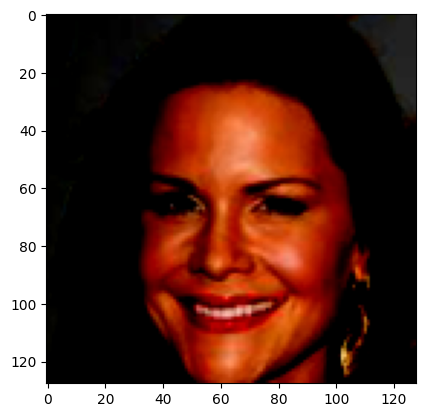

In [5]:
for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break
    
plt.imshow(np.transpose((features[3]), (1, 2, 0)))

In [6]:
logits, probas = classifier(features.to(device)[3, None])
print('Probability Smile %.2f%%' % (probas[0][1]*100))

_, probas = classifier(features.to(device)[3, None])
probas[:, 1].unsqueeze(1)

Probability Smile 99.99%


tensor([[0.9999]], device='cuda:0')

In [14]:
probas[:, 1].unsqueeze(1).round()

tensor([[1.]], device='cuda:0')

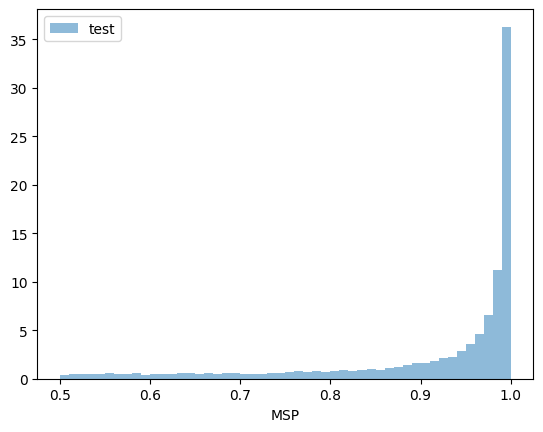

In [7]:
def get_MSP(dataloader, model, device):

    model.eval()

    msp = torch.zeros((len(dataloader.dataset)))
    idx = 0
    for X, y in dataloader:
        batch_size = X.shape[0]

        X, y = X.to(device), y.to(device)

        with torch.no_grad():
            # Compute prediction, loss and correct predictions
            logits, probas = model(X)
            max_softmax_proba = torch.max(torch.softmax(logits, axis=1), axis=1).values

        msp[idx:idx+batch_size] = max_softmax_proba
        idx += batch_size

    return msp

# msp_train = get_MSP(train_loader, classifier, device)
msp_test = get_MSP(test_loader, classifier, device)

plt.figure()
plt.xlabel('MSP')
# plt.hist(msp_train, alpha=0.5, bins=50, density=True, label='train')
plt.hist(msp_test, alpha=0.5, bins=50, density=True, label='test')
plt.legend()

# GAN

In [8]:
def postprocess_images(images):
    assert images.dim() == 4, "Expected 4D (B x C x H x W) image tensor, got {}D".format(images.dim())
    images = ((images + 1) / 2).clamp(0, 1) # scale
    # images = images[:, :, 2:30, 2:30] # remove padding
    return images

def plot_images_grid(images, title=''):
    images = images * 255
    images = images.to(torch.uint8)
    plt.figure()
    plt.imshow(vutils.make_grid(images.cpu(), pad_value=255).permute(1,2,0), vmin=0, vmax=255)
    plt.axis('off')
    plt.grid(False)
    plt.title(title)

In [9]:
path_model = path_main / 'uncertainty-conditioned-gan/results/stylegan2-training-runs' / '00015-ffhq128x128-auto2-classifCond'

# LOAD GENERATOR
if not str(path_model).endswith('pkl'):
    # find best model in folder
    with open(path_model / 'metric-fid50k_full.jsonl', 'r') as json_file:
        json_list = list(json_file)
    best_fid = 1e6
    for json_str in json_list:
        json_line = json.loads(json_str)
        if json_line['results']['fid50k_full'] < best_fid:
            best_fid = json_line['results']['fid50k_full']
            best_model = json_line['snapshot_pkl']
    print('Best FID: {:.2f} ; best model : {}'.format(best_fid, best_model))
    path_model = path_model / best_model
    with open(path_model, 'rb') as f:
        G = pickle.load(f)['G_ema'].eval().to(device)  # torch.nn.Module
else:
    with dnnlib.util.open_url(path_model) as f:
        G = legacy.load_network_pkl(f)['G_ema'].eval().requires_grad_(False).to(device)

Best FID: 14.14 ; best model : network-snapshot-007056.pkl


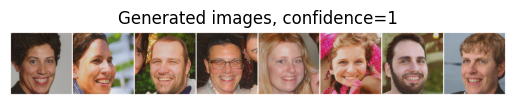

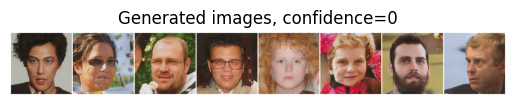

In [26]:
n_images = 8

z = torch.randn((n_images, G.z_dim), device=device)
c = torch.ones((n_images, 1), device=device)

ws = G.mapping(z, c, truncation_psi=1)
img = G.synthesis(ws, noise_mode='const', force_fp32=True)
img = postprocess_images(img)
plot_images_grid(img, title='Generated images, confidence=1')
plt.show()
# print('confidences:', F.softmax(classifier(img), dim=1).max(dim=1).values)

# change only classif condition
proba = 0
c = proba * torch.ones((n_images, 1), device=device)

ws = G.mapping(z, c, truncation_psi=1)
img = G.synthesis(ws, noise_mode='const', force_fp32=True)
img = postprocess_images(img)
plot_images_grid(img, title=f'Generated images, confidence={proba}')
plt.show()
# print('confidences:', F.softmax(classifier(img), dim=1).max(dim=1).values)



Text(0, 0.5, 'confidence out')

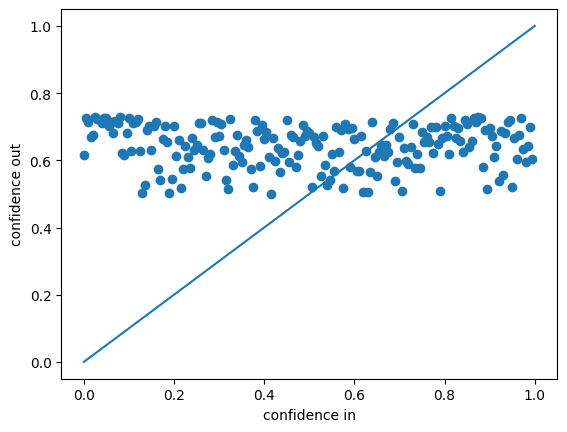

In [11]:
n_images = 200

z = torch.randn((n_images, G.z_dim), device=device)
# uniform confidence
confid_in = torch.arange(0, 1, 0.005, device=device).unsqueeze(1)
c = confid_in

ws = G.mapping(z, c, truncation_psi=1)
img = G.synthesis(ws, noise_mode='const', force_fp32=True)
img = postprocess_images(img)
img = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(img)
confid_out = F.softmax(classifier(img)[1], dim=1).max(dim=1).values

plt.figure()
plt.plot([0, 1], [0, 1])
plt.scatter(confid_in.cpu(), confid_out.cpu())
plt.xlabel('confidence in')
plt.ylabel('confidence out')

In [12]:
transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(img)

tensor([[[[-1.8704, -1.8106, -1.8138,  ...,  0.3711,  0.4340,  0.3374],
          [-1.7986, -1.8063, -1.8302,  ...,  0.3178,  0.2991,  0.4237],
          [-1.7601, -1.7791, -1.7913,  ...,  0.3300,  0.3530,  0.3544],
          ...,
          [-2.1432, -2.0618, -2.0379,  ..., -2.4273, -2.3460, -2.3483],
          [-2.3414, -2.0626, -2.1179,  ..., -2.3566, -2.2672, -2.2434],
          [-2.2227, -2.2490, -2.1924,  ..., -2.3770, -2.2657, -2.5133]],

         [[-2.3154, -2.2654, -2.2661,  ..., -0.1219, -0.0308, -0.1358],
          [-2.2747, -2.2783, -2.2948,  ..., -0.1558, -0.1269, -0.0349],
          [-2.2370, -2.2653, -2.2604,  ..., -0.1742, -0.0838, -0.0642],
          ...,
          [-2.4215, -2.3757, -2.3750,  ..., -2.5626, -2.5026, -2.4890],
          [-2.6303, -2.3948, -2.4407,  ..., -2.5115, -2.4413, -2.4097],
          [-2.5021, -2.5037, -2.4791,  ..., -2.5097, -2.4132, -2.7061]],

         [[-2.8041, -2.7358, -2.7123,  ..., -0.9536, -0.8446, -0.8684],
          [-2.7649, -2.7236, -